In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod


# =========================================================
# 0. Base Buy / Sell Factor：抽象介面
# =========================================================

class BaseBuyFactor(ABC):
    """
    所有「買入策略因子」的抽象基底類別
    必須實作:
        - reset()
        - generate()
    """

    def __init__(self, df, **kwargs):
        self.df = df
        self.params = kwargs
        self.factor_name = f"{self.__class__.__name__}_{kwargs}"
        self.reset()

    @abstractmethod
    def reset(self):
        """策略內部變數初始化"""
        pass

    @abstractmethod
    def generate(self) -> np.ndarray:
        """
        回傳買入訊號陣列：
        - 1 = 當天買入
        - NaN = 無操作
        """
        pass


class BaseSellFactor(ABC):
    """
    所有「賣出策略因子」的抽象基底類別
    必須實作:
        - reset()
        - generate()
    """

    def __init__(self, df, **kwargs):
        self.df = df
        self.params = kwargs
        self.factor_name = f"{self.__class__.__name__}_{kwargs}"
        self.reset()

    @abstractmethod
    def reset(self):
        """初始化策略狀態"""
        pass

    @abstractmethod
    def generate(self) -> np.ndarray:
        """
        回傳賣出訊號陣列：
        - 0 = 當天賣出
        - NaN = 無操作
        """
        pass


# =========================================================
# 1. BreakoutBuyFactor：N 日向上突破買入
# =========================================================

class BreakoutBuyFactor(BaseBuyFactor):
    """
    N 日向上突破：
    若今日收盤價 == 過去 xd 日最高價 → 發出買入訊號
    並且在之後 xd 天內忽略新的突破（skip_days）
    """

    def reset(self):
        self.skip_days = 0

    def generate(self):
        df = self.df
        xd = self.params["xd"]
        signal = np.full(len(df), np.nan)

        close = df["Close"].values

        for i in range(len(df)):
            if i < xd:
                continue

            # 忽略突破後的連續 N 天信號（防止瘋狂加碼）
            if self.skip_days > 0:
                self.skip_days -= 1
                continue

            rolling_high = close[i - xd + 1 : i + 1].max()

            # 收盤價創 xd 日新高 → 發出買入
            if close[i] == rolling_high:
                signal[i] = 1
                self.skip_days = xd

        return signal


# =========================================================
# 2. BreakdownSellFactor：N 日向下突破賣出
# =========================================================

class BreakdownSellFactor(BaseSellFactor):
    """
    N 日向下突破：
    若今日收盤價 == 過去 xd 日最低價 → 發出賣出訊號（清倉）
    """
    
    def reset(self):
        pass

    def generate(self):
        df = self.df
        xd = self.params["xd"]
        signal = np.full(len(df), np.nan)

        close = df["Close"].values

        for i in range(len(df)):
            if i < xd:
                continue

            rolling_low = close[i - xd + 1 : i + 1].min()

            # 收盤價創 xd 日新低 → 賣出
            if close[i] == rolling_low:
                signal[i] = 0

        return signal


# =========================================================
# 3. Benchmark：基準（單純 buy & hold）
# =========================================================

class Benchmark:
    @staticmethod
    def compute_log_ret(df: pd.DataFrame) -> pd.Series:
        """基準對數報酬率（持有一檔標的不交易）"""
        close = df["Close"]
        return np.log(close / close.shift(1))


# =========================================================
# 4. Backtester：單檔股票多因子回測引擎
# =========================================================

class Backtester:
    def __init__(self, df: pd.DataFrame,
                 buy_factors=None,
                 sell_factors=None,
                 initial_capital: float = 1000000.0):
        """
        df: 價格資料，index 為日期，至少包含 'Close'
        buy_factors: 買入因子設定 list
            e.g. [{"class": BreakoutBuyFactor, "xd": 60}, ...]
        sell_factors: 賣出因子設定 list
            e.g. [{"class": BreakdownSellFactor, "xd": 20}, ...]
        initial_capital: 初始資金（只用來算 equity，不做分批加減）
        """
        self.raw_df = df.copy()
        self.df = df.copy()
        self.buy_factors = buy_factors or []
        self.sell_factors = sell_factors or []
        self.initial_capital = initial_capital

        self.buy_cols = []
        self.sell_cols = []
        self.result = None
        self.trades = None
        self.stats = None

    # ---------------------
    # 主流程
    # ---------------------
    def run(self, show_plot=False, plot_start=None, plot_end=None):
        self._apply_factors()
        self._build_position()
        self._compute_equity()
        self._extract_trades()
        self._compute_stats()

        # 🔥 如果使用者要求 → 畫圖
        if show_plot:
            self._plot_trades(plot_start, plot_end)

        return self.result, self.trades, self.stats

    # ---------------------
    # 產生各因子訊號欄位
    # ---------------------
    def _apply_factors(self):
        df = self.df

        df["buy_factor_trigger"] = ""
        df["sell_factor_trigger"] = ""

        # 買入因子
        for f in self.buy_factors:
            FactorClass = f["class"]
            params = {k: v for k, v in f.items() if k != "class"}
            factor = FactorClass(df, **params)

            col = factor.factor_name
            self.buy_cols.append(col)

            df[col] = factor.generate()

            # 記錄：哪個因子產生買訊
            df.loc[df[col] == 1, "buy_factor_trigger"] += (col + ";")

        # 賣出因子
        for f in self.sell_factors:
            FactorClass = f["class"]
            params = {k: v for k, v in f.items() if k != "class"}
            factor = FactorClass(df, **params)

            col = factor.factor_name
            self.sell_cols.append(col)

            df[col] = factor.generate()

            # 記錄：哪個因子產生賣訊
            df.loc[df[col] == 0, "sell_factor_trigger"] += (col + ";")

    # ---------------------
    # 建立 signal & position（持股狀態）
    # ---------------------
    def _build_position(self):
        df = self.df

        # 買入：任一買入因子 == 1 就視為買入訊號
        if self.buy_cols:
            buy_signal = df[self.buy_cols].max(axis=1)
        else:
            buy_signal = pd.Series(np.nan, index=df.index)

        # 賣出：任一賣出因子 == 0 就視為賣出訊號
        if self.sell_cols:
            sell_signal = df[self.sell_cols].min(axis=1)
        else:
            sell_signal = pd.Series(np.nan, index=df.index)

        # 綜合 signal：優先考慮賣出，其次買入
        combined = pd.Series(np.nan, index=df.index)

        combined[buy_signal == 1] = 1   # 當天出現買入事件
        combined[sell_signal == 0] = 0  # 當天出現賣出事件（清倉）

        df["raw_signal"] = combined

        # position: 持股狀態
        # 規則：最後一次非 NaN 的 signal 決定目前狀態（1=持股, 0=空手）
        position = combined.ffill().fillna(0)

        # 為了避免「當天訊號吃到當天報酬」（偷看未來）
        # 我們用 position.shift(1) 來決定策略報酬
        df["position"] = position

    # ---------------------
    # 計算基準與策略的 equity curve
    # ---------------------
    def _compute_equity(self):
        df = self.df

        # 基準：單純買入持有的對數報酬率
        df["log_ret"] = Benchmark.compute_log_ret(df)

        # 策略報酬：用「前一天」的持股狀態乘上今天的 log return
        df["strategy_log_ret"] = df["position"].shift(1).fillna(0) * df["log_ret"]

        # 累積報酬 → 換回金額
        df["benchmark_equity"] = self.initial_capital * np.exp(df["log_ret"].cumsum())
        df["strategy_equity"] = self.initial_capital * np.exp(df["strategy_log_ret"].cumsum())
        
        # 🔥 修正第一筆 NaN = 初始資金
        df.loc[df.index[0], "benchmark_equity"] = self.initial_capital
        df.loc[df.index[0], "strategy_equity"] = self.initial_capital

        self.result = df

    # ---------------------
    # 產生交易紀錄（每筆進出場）
    # ---------------------
    def _extract_trades(self):
        df = self.result
        pos = df["position"]
        change = pos.diff()

        entries = change[change == 1].index
        exits = change[change == -1].index

        if len(entries) > len(exits):
            exits = exits.append(pd.Index([df.index[-1]]))

        records = []
        for entry_date, exit_date in zip(entries, exits):
            records.append({
                "entry_date": entry_date,
                "exit_date": exit_date,
                "entry_price": df.loc[entry_date, "Close"],
                "exit_price": df.loc[exit_date, "Close"],
                "holding_days": (exit_date - entry_date).days,
                "return_pct": df.loc[exit_date, "Close"] / df.loc[entry_date, "Close"] - 1,
                "buy_factor": df.loc[entry_date, "buy_factor_trigger"],
                "sell_factor": df.loc[exit_date, "sell_factor_trigger"],
            })

        self.trades = pd.DataFrame(records)

    # ---------------------
    # 計算一些基本績效指標
    # ---------------------
    def _compute_stats(self):
        df = self.result

        # ----------------------------
        # 策略績效（strategy）
        # ----------------------------
        total_ret = df["strategy_equity"].iloc[-1] / self.initial_capital

        days = (df.index[-1] - df.index[0]).days
        years = days / 365.0 if days > 0 else 1.0
        annual_ret = (1 + total_ret) ** (1 / years) - 1 if years > 0 else total_ret

        daily_ret = df["strategy_log_ret"].dropna()
        if len(daily_ret) > 1 and daily_ret.std() > 0:
            vol = daily_ret.std() * np.sqrt(252)
            sharpe = daily_ret.mean() / daily_ret.std() * np.sqrt(252)
        else:
            vol = np.nan
            sharpe = np.nan

        equity = df["strategy_equity"]
        roll_max = equity.cummax()
        dd = equity / roll_max - 1.0
        max_dd = dd.min()

        # ----------------------------
        # 基準績效（benchmark）
        # ----------------------------
        benchmark_total_ret = df["benchmark_equity"].iloc[-1] / self.initial_capital
        benchmark_annual_ret = (1 + benchmark_total_ret) ** (1 / years) - 1 if years > 0 else benchmark_total_ret

        benchmark_daily_ret = df["log_ret"].dropna()
        if len(benchmark_daily_ret) > 1 and benchmark_daily_ret.std() > 0:
            benchmark_vol = benchmark_daily_ret.std() * np.sqrt(252)
            benchmark_sharpe = benchmark_daily_ret.mean() / benchmark_daily_ret.std() * np.sqrt(252)
        else:
            benchmark_vol = np.nan
            benchmark_sharpe = np.nan

        bench_equity = df["benchmark_equity"]
        bench_roll_max = bench_equity.cummax()
        bench_dd = bench_equity / bench_roll_max - 1.0
        benchmark_max_dd = bench_dd.min()

        # ----------------------------
        # 統整最終績效（中文）
        # ----------------------------
        self.stats = {
            "策略_總報酬率": total_ret,
            "策略_年化報酬率": annual_ret,
            "策略_年化波動率": vol,
            "策略_Sharpe": sharpe,
            "策略_最大回撤": max_dd,
            "策略_交易次數": 0 if self.trades is None else len(self.trades),

            "基準_總報酬率": benchmark_total_ret,
            "基準_年化報酬率": benchmark_annual_ret,
            "基準_年化波動率": benchmark_vol,
            "基準_Sharpe": benchmark_sharpe,
            "基準_最大回撤": benchmark_max_dd,
        }

        
    # =========================================================
    # ★ 交易視覺化
    # =========================================================
    def _plot_trades(self, start=None, end=None):
        df = self.result.copy()
        trades = self.trades

        if start:
            start = pd.to_datetime(start)
            df = df[df.index >= start]
        if end:
            end = pd.to_datetime(end)
            df = df[df.index <= end]

        plt.figure(figsize=(18, 6))

        # ---- 黑色收盤線 ----
        plt.plot(df.index, df["Close"], color="black", label="Close")

        # ---- 藍色底色 ----
        plt.fill_between(df.index, 0, df["Close"], color="blue", alpha=0.05)

        # ---- 逐筆畫出交易 ----
        for _, t in trades.iterrows():
            buy = t["entry_date"]
            sell = t["exit_date"]
            buy_price = t["entry_price"]
            sell_price = t["exit_price"]
            pnl = sell_price - buy_price
            pnl_rate = t["return_pct"]

            color = "green" if pnl > 0 else "red"

            # 區間 mask
            mask = (df.index >= buy) & (df.index <= sell)

            # 區間背景
            plt.fill_between(df.index[mask],
                            0, df["Close"][mask],
                            color=color, alpha=0.28)

            # Buy / Sell 散點
            plt.scatter(buy, buy_price, color="blue", s=80)
            plt.scatter(sell, sell_price, color="orange", s=80)

            # ⭐ 取得觸發策略名稱
            buy_label = df.loc[buy, "buy_factor_trigger"] if "buy_factor_trigger" in df.columns else ""
            sell_label = df.loc[sell, "sell_factor_trigger"] if "sell_factor_trigger" in df.columns else ""

            # 暫時註解掉文字不然太亂了
            # TODO： 到時候用參數選擇要關還開
            # # ⭐ 在圖上標文字
            # plt.text(buy, buy_price,
            #         f"{buy_label}",
            #         fontsize=9, color="blue",
            #         ha="right", va="bottom")

            # plt.text(sell, sell_price,
            #         f"{sell_label}",
            #         fontsize=9, color="orange",
            #         ha="left", va="top")

            # 盈虧數字
            plt.text(sell, sell_price,
                    f"{pnl:+.2f} ({pnl_rate:+.2f}%)",
                    color=color, fontsize=9,
                    ha="left", va="bottom")

        plt.title("Backtest Trade Visualization")
        plt.grid(True)
        plt.legend()
        plt.show()



In [265]:
# 下載特斯拉資料作為範例

import yfinance as yf

df = yf.download("AAPL", start="2020-01-01")
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)  # 避免 MultiIndex 問題

df

/var/folders/k0/mjnvdkdj7sn_zbtz76h68xr40000gn/T/ipykernel_63374/2204835916.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2020-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,72.468246,72.528566,71.223244,71.476585,135480400
2020-01-03,71.763748,72.523777,71.539360,71.696190,146322800
2020-01-06,72.335556,72.374162,70.634539,70.885472,118387200
2020-01-07,71.995369,72.600975,71.775804,72.345220,108872000
2020-01-08,73.153496,73.455095,71.698581,71.698581,132079200
...,...,...,...,...,...
2025-11-10,269.429993,273.730011,267.459991,268.959991,41312400
2025-11-11,275.250000,275.910004,269.799988,269.809998,46208300
2025-11-12,273.470001,275.730011,271.700012,275.000000,48398000


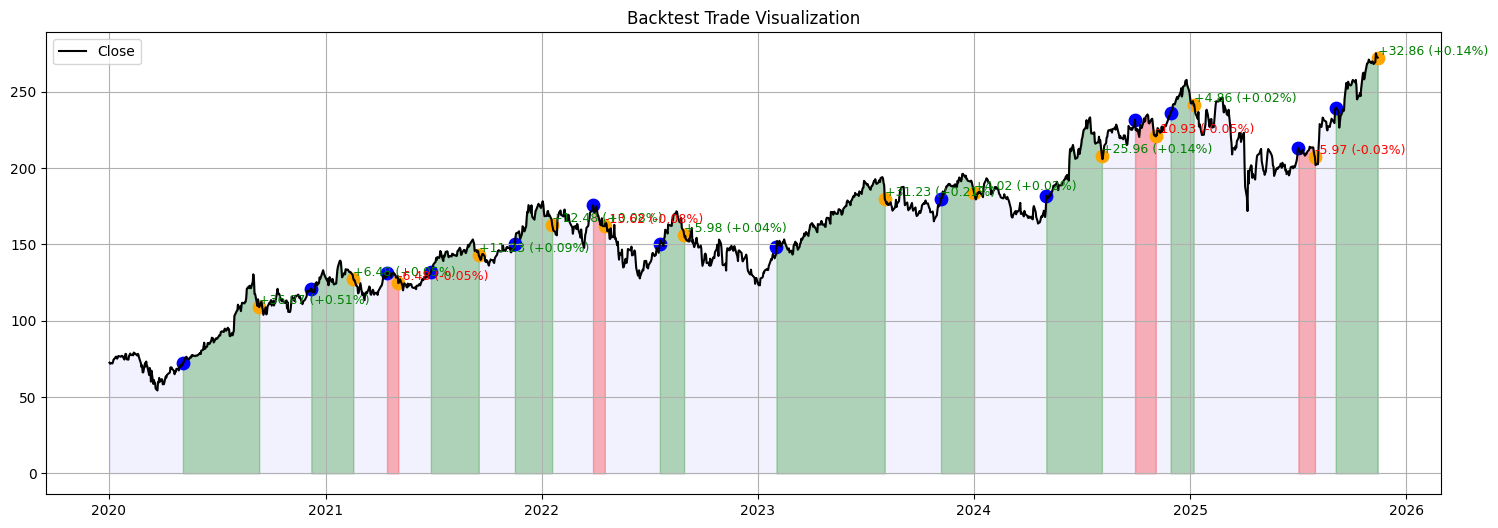

=== 績效指標 ===
策略_總報酬率 : 2.5946098681191034
策略_年化報酬率 : 0.24348258549621438
策略_年化波動率 : 0.17065279179569318
策略_Sharpe : 0.9538770660408983
策略_最大回撤 : -0.20328329919255017
策略_交易次數 : 14
基準_總報酬率 : 3.7590257384331425
基準_年化報酬率 : 0.30435622559337583
基準_年化波動率 : 0.320083527933203
基準_Sharpe : 0.7063033417348294
基準_最大回撤 : -0.33360510959893674

=== 交易紀錄（前 5 筆） ===
  entry_date  exit_date  entry_price  exit_price  holding_days  return_pct  \
0 2020-05-05 2020-09-11    71.965500  108.838875           129    0.512376   
1 2020-12-08 2021-02-17   121.078003  127.556831            71    0.053510   
2 2021-04-15 2021-05-04   131.125000  124.641853            19   -0.049442   
3 2021-06-28 2021-09-17   131.621140  142.850494            81    0.085316   
4 2021-11-17 2022-01-19   150.336304  162.814529            63    0.083002   

                                          buy_factor  \
0                      BreakoutBuyFactor_{'xd': 42};   
1  BreakoutBuyFactor_{'xd': 60};BreakoutBuyFactor...   
2           

<Axes: xlabel='Date'>

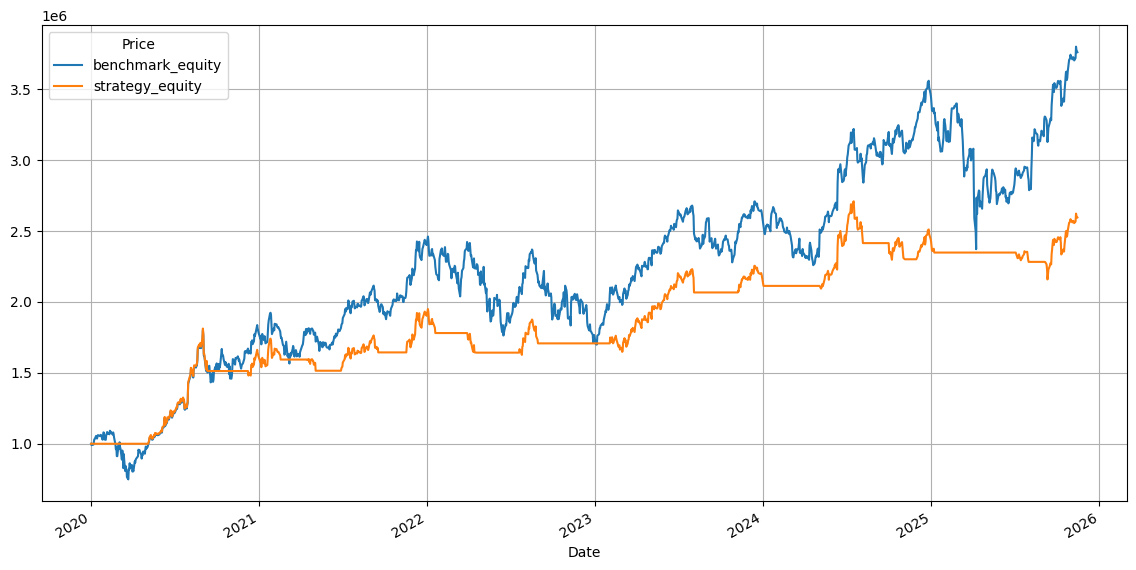

In [266]:
# Test 1
# 設定買入因子
buy_factors = [
    {"class": BreakoutBuyFactor, "xd": 60},
    {"class": BreakoutBuyFactor, "xd": 42},
]

# 設定賣出因子
sell_factors = [
    {"class": BreakdownSellFactor, "xd": 120},
    {"class": BreakdownSellFactor, "xd": 20}
]

# 執行單支股票回測
# 參數：
# df: 價格資料，index 為日期，至少包含 'Close'
# buy_factors: 買入因子設定 list
# sell_factors: 賣出因子設定 list
# initial_capital: 初始資金（只用來算 equity，不做分批加減）
# 回傳：
# result_df: 策略報酬率
# trades_df: 交易紀錄
# stats: 績效指標

bt_test1 = Backtester(df, buy_factors=buy_factors, sell_factors=sell_factors, initial_capital=1_000_000)
result_df_test1, trades_df_test1, stats_test1 = bt_test1.run(show_plot=True)

print("=== 績效指標 ===")
for k, v in stats_test1.items():
    print(k, ":", v)

print("\n=== 交易紀錄（前 5 筆） ===")
print(trades_df_test1.head())

# 策略 vs 基準績效曲線
result_df_test1[["benchmark_equity", "strategy_equity"]].plot(figsize=(14, 7), grid=True)

In [267]:
# 可以看到績效表現不是很好
# 量化投資策略會加上止盈止損策略
# 這邊實作 AtrStopSellFactor 來當作止盈止損賣出因子
class AtrStopSellFactor(BaseSellFactor):

    def reset(self):
        self.in_position = False
        self.entry_price = None

    def _ensure_atr(self):
        df = self.df
        if "atr14" not in df or "atr21" not in df:
            high_low = df["High"] - df["Low"]
            high_close = (df["High"] - df["Close"].shift(1)).abs()
            low_close = (df["Low"] - df["Close"].shift(1)).abs()
            tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

            df["atr14"] = tr.rolling(14).mean().fillna(0)
            df["atr21"] = tr.rolling(21).mean().fillna(0)

    def generate(self):
        df = self.df
        self._ensure_atr()

        n_loss = self.params.get("stop_loss_n")
        n_win = self.params.get("stop_win_n")

        signal = np.full(len(df), np.nan)

        close = df["Close"].values
        atr14 = df["atr14"].values
        atr21 = df["atr21"].values

        # 找出所有買入 raw signal（由你的 buy factors 產生）
        buy_cols = [c for c in df.columns if "BuyFactor" in c]
        raw_buy = df[buy_cols].max(axis=1).fillna(0).values

        for i in range(len(df)):

            # 若今天發生買入 → 記錄 entry_price
            if raw_buy[i] == 1:
                self.in_position = True
                self.entry_price = close[i]
                continue

            # 若沒有持倉 → 略過
            if not self.in_position:
                continue

            profit = close[i] - self.entry_price
            stop_base = atr14[i] + atr21[i]

            # ---- 止盈 ----
            if n_win is not None and profit > n_win * stop_base:
                signal[i] = 0
                self.in_position = False
                self.entry_price = None
                continue

            # ---- 止損 ----
            if n_loss is not None and profit < -n_loss * stop_base:
                signal[i] = 0
                self.in_position = False
                self.entry_price = None
                continue

        return signal

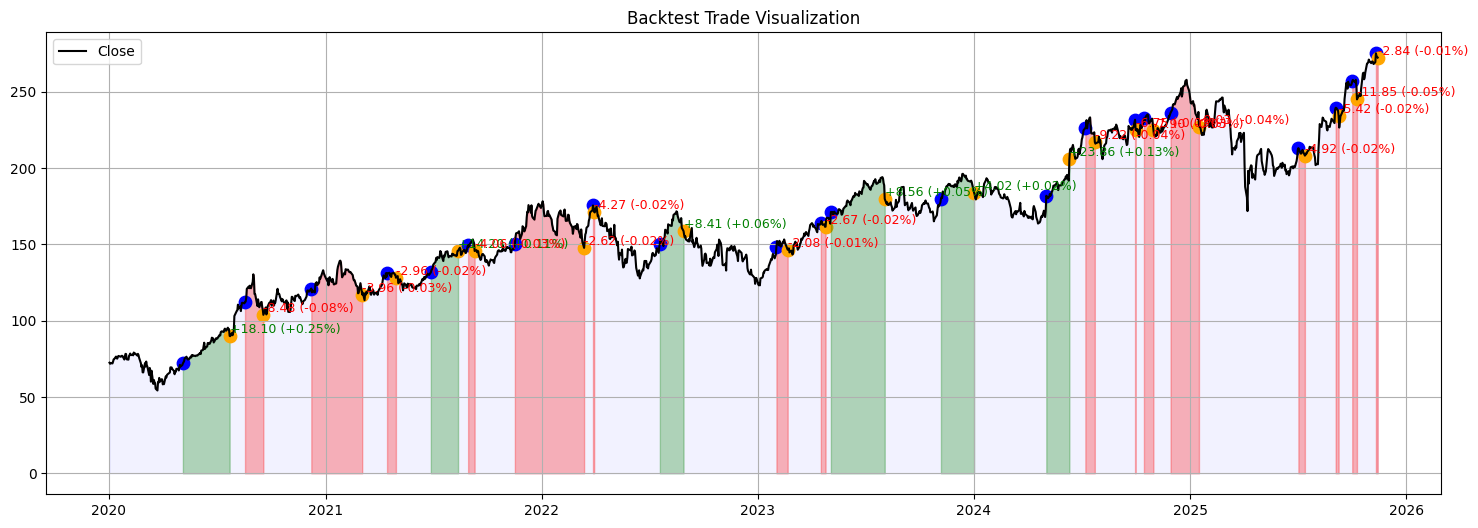

=== 績效指標 ===
策略_總報酬率 : 1.0963448444103305
策略_年化報酬率 : 0.13436329985365703
策略_年化波動率 : 0.15788058027128943
策略_Sharpe : 0.09946888964888716
策略_最大回撤 : -0.24722207464050872
策略_交易次數 : 22
基準_總報酬率 : 3.7590257384331425
基準_年化報酬率 : 0.30435622559337583
基準_年化波動率 : 0.320083527933203
基準_Sharpe : 0.7063033417348294
基準_最大回撤 : -0.33360510959893674

=== 交易紀錄（前 5 筆） ===
  entry_date  exit_date  entry_price  exit_price  holding_days  return_pct  \
0 2020-05-05 2020-07-23    71.965500   90.062141            79    0.251463   
1 2020-08-18 2020-09-18   112.300835  103.824516            31   -0.075479   
2 2020-12-08 2021-03-04   121.078003  117.115585            86   -0.032726   
3 2021-04-15 2021-04-30   131.125000  128.161270            15   -0.022602   
4 2021-06-28 2021-08-13   131.621140  145.823669            46    0.107905   

                                          buy_factor  \
0                      BreakoutBuyFactor_{'xd': 42};   
1                      BreakoutBuyFactor_{'xd': 60};   
2  Breakout

<Axes: xlabel='Date'>

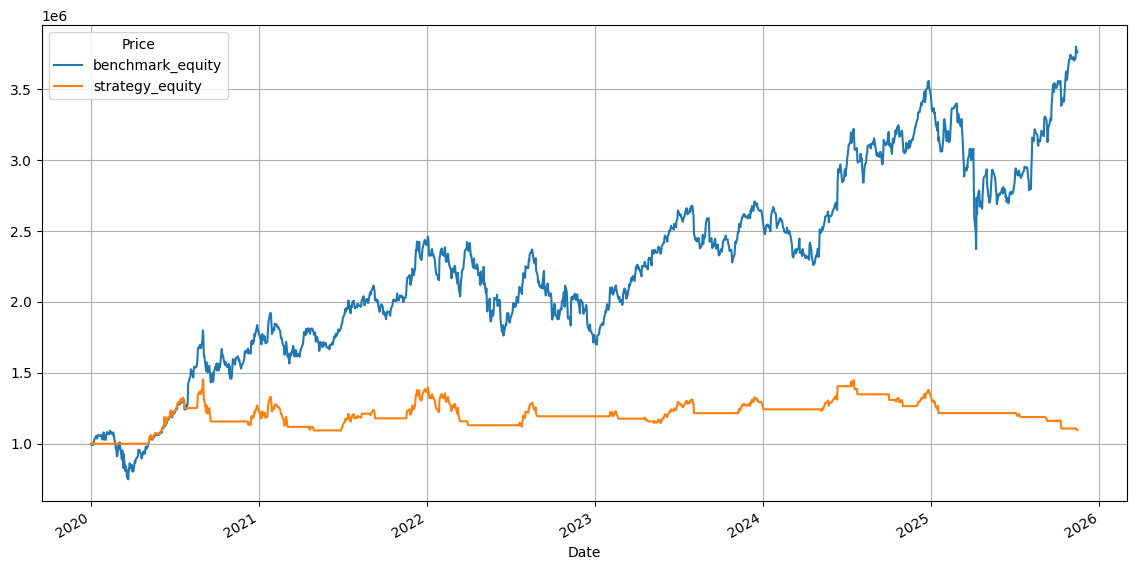

In [268]:
# Test 2
# 加入 AtrStopSellFactor 來當作止盈止損賣出因子
buy_factors = [
    {"class": BreakoutBuyFactor, "xd": 60},
    {"class": BreakoutBuyFactor, "xd": 42},
]

# 先前的賣出因子調整
sell_factors = [
    {"class": BreakdownSellFactor, "xd": 120},
    # 加上ATR止盈止損
    {"class": AtrStopSellFactor, "stop_loss_n": 0.5, "stop_win_n": 3.0}
]

bt_test2 = Backtester(df, buy_factors=buy_factors, sell_factors=sell_factors, initial_capital=1_000_000)
result_df_test2, trades_df_test2, stats_test2 = bt_test2.run(show_plot=True)

print("=== 績效指標 ===")
for k, v in stats_test2.items():
    print(k, ":", v)

print("\n=== 交易紀錄（前 5 筆） ===")
print(trades_df_test2.head())

# 策略 vs 基準績效曲線
result_df_test2[["benchmark_equity", "strategy_equity"]].plot(figsize=(14, 7), grid=True)


In [269]:
# 更進一步： 量化交易會有風險控制，當天股價大量下跌的時候會果斷採取平倉
# 實作 RiskStopSellFactor 來當作風險控制賣出因子
class RiskStopSellFactor(BaseSellFactor):
    """
    風險控制：
    若今天的跌幅（昨收 - 今收） > ATR21 * pre_atr_n
    → 強制止損賣出
    """

    def reset(self):
        pass

    # -----------------------------------------------------
    # 如果 df 沒有 ATR 相關欄位，補上
    # -----------------------------------------------------
    def _ensure_atr(self):
        df = self.df

        if "atr14" not in df.columns or "atr21" not in df.columns:
            high_low = df["High"] - df["Low"]
            high_close = (df["High"] - df["Close"].shift(1)).abs()
            low_close = (df["Low"] - df["Close"].shift(1)).abs()

            tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

            df["atr14"] = tr.rolling(14).mean()
            df["atr21"] = tr.rolling(21).mean()

            df[["atr14", "atr21"]] = df[["atr14", "atr21"]].fillna(0)

    # -----------------------------------------------------
    # generate(): 回傳賣出訊號
    # -----------------------------------------------------
    def generate(self):
        df = self.df

        # 確保 ATR 欄位存在
        self._ensure_atr()

        pre_atr_n = self.params.get("pre_atr_n", 1.5)  # 預設 1.5（與阿布一致）
        signal = np.full(len(df), np.nan)

        close = df["Close"].values
        preclose = df["Close"].shift(1).values
        atr21 = df["atr21"].values

        for i in range(1, len(df)):
            drop_amount = preclose[i] - close[i]

            # ✦ 今日跌幅超過 ATR21 × 倍數 → 強制賣出
            if drop_amount > atr21[i] * pre_atr_n:
                signal[i] = 0  # 賣出

        return signal

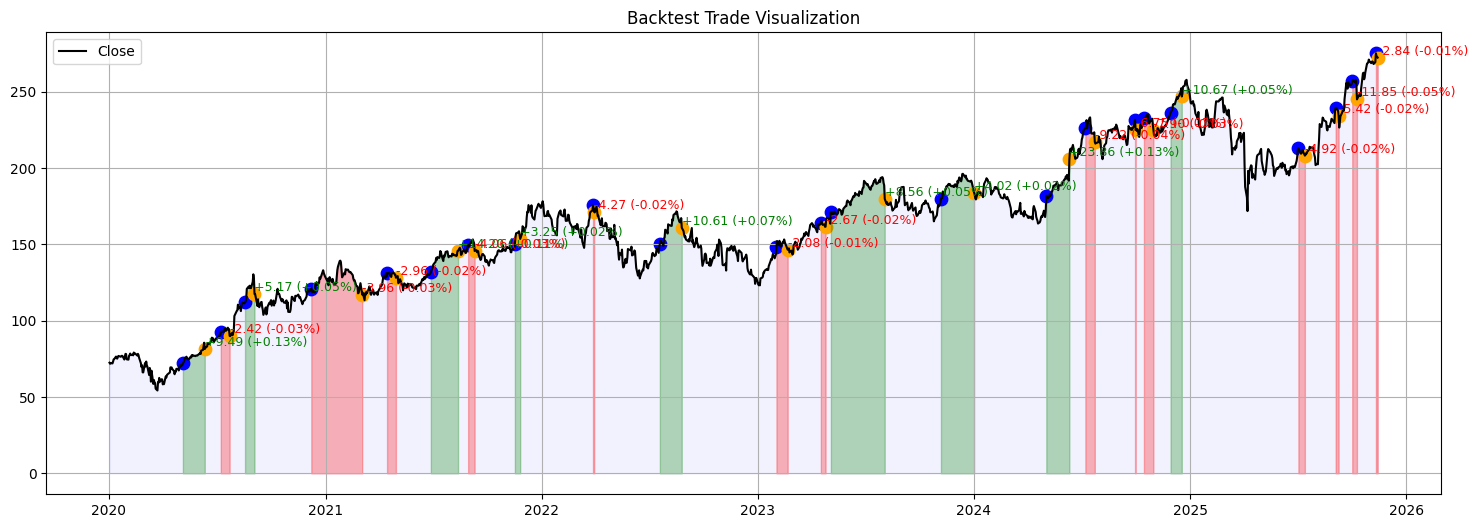

=== 績效指標 ===
策略_總報酬率 : 1.0963448444103305
策略_年化報酬率 : 0.13436329985365703
策略_年化波動率 : 0.15788058027128943
策略_Sharpe : 0.09946888964888716
策略_最大回撤 : -0.24722207464050872
策略_交易次數 : 22
基準_總報酬率 : 3.7590257384331425
基準_年化報酬率 : 0.30435622559337583
基準_年化波動率 : 0.320083527933203
基準_Sharpe : 0.7063033417348294
基準_最大回撤 : -0.33360510959893674

=== 交易紀錄（前 5 筆） ===
  entry_date  exit_date  entry_price  exit_price  holding_days  return_pct  \
0 2020-05-05 2020-06-11    71.965500   81.458000            37    0.131903   
1 2020-07-08 2020-07-23    92.484795   90.062141            15   -0.026195   
2 2020-08-18 2020-09-03   112.300835  117.468269            16    0.046014   
3 2020-12-08 2021-03-04   121.078003  117.115585            86   -0.032726   
4 2021-04-15 2021-04-30   131.125000  128.161270            15   -0.022602   

                                          buy_factor  \
0                      BreakoutBuyFactor_{'xd': 42};   
1                      BreakoutBuyFactor_{'xd': 42};   
2          

<Axes: xlabel='Date'>

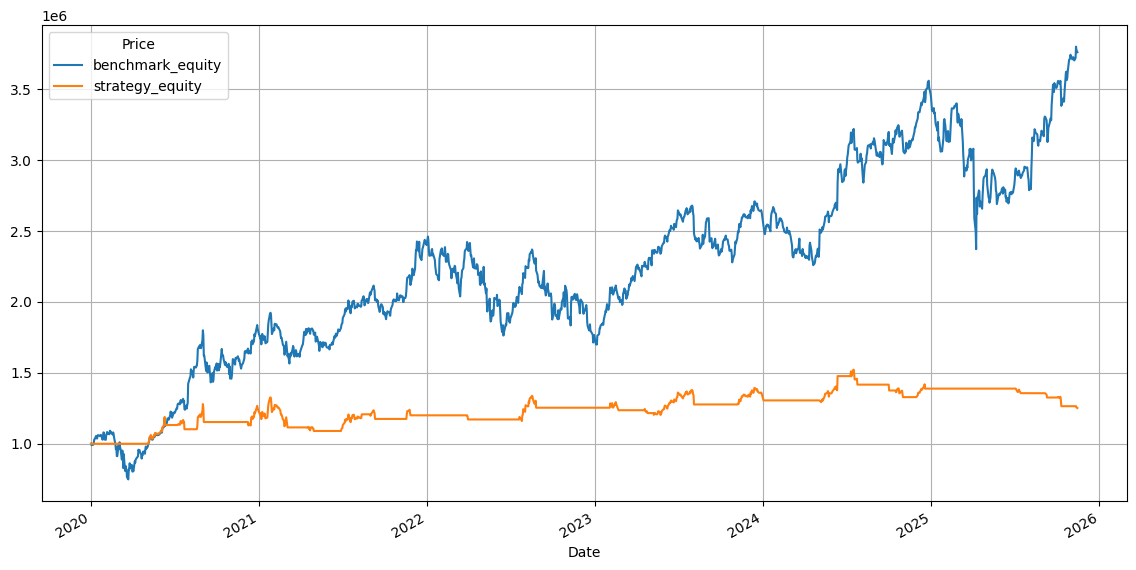

In [270]:
# Test 3
# 加入止損策略
buy_factors = [
    {"class": BreakoutBuyFactor, "xd": 60},
    {"class": BreakoutBuyFactor, "xd": 42},
]

# 先前的賣出因子調整
sell_factors = [
    {"class": BreakdownSellFactor, "xd": 120},
    # 加上ATR止盈止損
    {"class": AtrStopSellFactor, "stop_loss_n": 0.5, "stop_win_n": 3.0},
    # 加入風險控制策略
    {"class": RiskStopSellFactor, "pre_atr_n": 1.5}
]

bt_test3 = Backtester(df, buy_factors=buy_factors, sell_factors=sell_factors, initial_capital=1_000_000)
result_df_test3, trades_df_test3, stats_test3 = bt_test3.run(show_plot=True)

print("=== 績效指標 ===")
for k, v in stats_test2.items():
    print(k, ":", v)

print("\n=== 交易紀錄（前 5 筆） ===")
print(trades_df_test3.head())

# 策略 vs 基準績效曲線
result_df_test3[["benchmark_equity", "strategy_equity"]].plot(figsize=(14, 7), grid=True)

In [271]:
# 再加入一個保護性止盈策略試試
class CloseAtrStopSellFactor(BaseSellFactor):
    """
    Trailing ATR 止盈
    close_atr_n：觸發止盈的 ATR 倍數（如 1.2）
    """

    def reset(self):
        self.in_position = False
        self.entry_price = None
        self.max_close = None  # 持倉期間最高收盤價

    def _ensure_atr(self):
        df = self.df
        if "atr21" not in df:
            high_low = df["High"] - df["Low"]
            high_close = (df["High"] - df["Close"].shift(1)).abs()
            low_close = (df["Low"] - df["Close"].shift(1)).abs()
            tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
            df["atr21"] = tr.rolling(21).mean().fillna(0)

    def generate(self):
        df = self.df
        close_atr_n = self.params.get("close_atr_n", 1.2)

        self._ensure_atr()

        close = df["Close"].values
        atr21 = df["atr21"].values

        signal = np.full(len(df), np.nan)

        # 找出所有買入訊號（你的邏輯：col 名稱中有 BuyFactor）
        buy_cols = [c for c in df.columns if "BuyFactor" in c]
        raw_buy = df[buy_cols].max(axis=1).fillna(0).values

        for i in range(len(df)):

            # ---------- 若當天觸發買入 ----------
            if raw_buy[i] == 1:
                self.in_position = True
                self.entry_price = close[i]
                self.max_close = close[i]
                continue

            # ---------- 若沒有持倉 ----------
            if not self.in_position:
                continue

            # 更新最大價格
            self.max_close = max(self.max_close, close[i])

            # Step 1：必須先獲利超過 1×ATR
            if self.max_close - self.entry_price <= atr21[i]:
                continue

            # Step 2：下降幅度超過 ATR 倍數 ⇒ 觸發止盈
            if (self.max_close - close[i]) > atr21[i] * close_atr_n:
                signal[i] = 0  # 賣出
                self.in_position = False
                self.entry_price = None
                self.max_close = None

        return signal

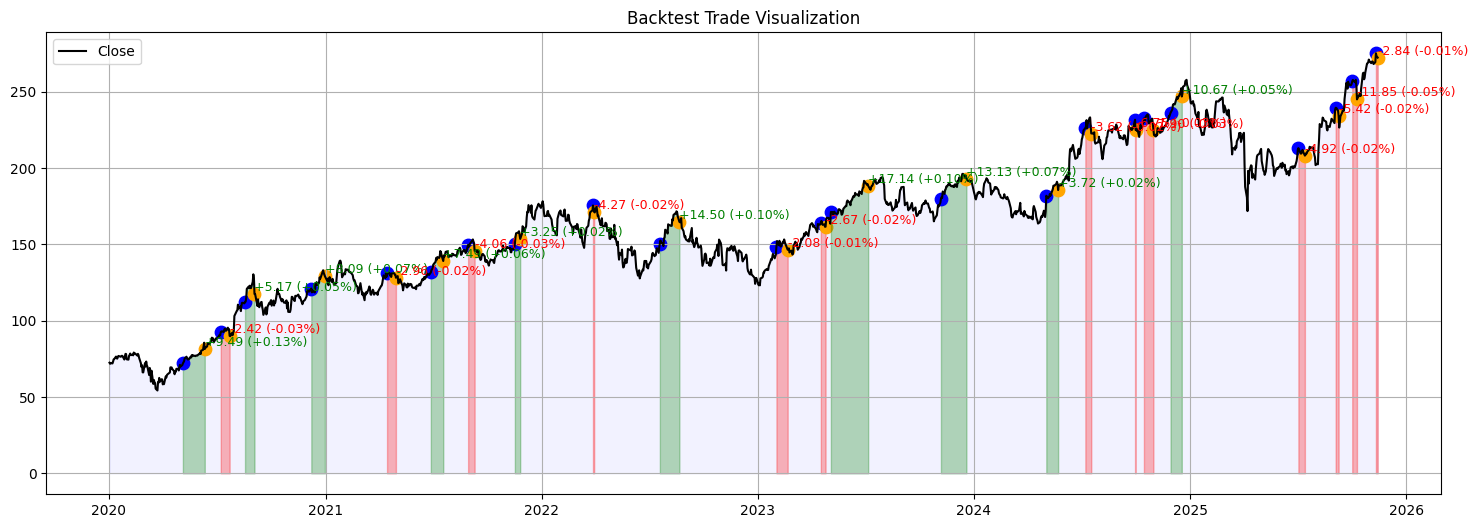

=== 績效指標 ===
策略_總報酬率 : 1.3724105207952453
策略_年化報酬率 : 0.15851877425669225
策略_年化波動率 : 0.10444731588144845
策略_Sharpe : 0.5174696336524426
策略_最大回撤 : -0.15647461995289325
策略_交易次數 : 23
基準_總報酬率 : 3.7590257384331425
基準_年化報酬率 : 0.30435622559337583
基準_年化波動率 : 0.320083527933203
基準_Sharpe : 0.7063033417348294
基準_最大回撤 : -0.33360510959893674

=== 交易紀錄（前 5 筆） ===
  entry_date  exit_date  entry_price  exit_price  holding_days  return_pct  \
0 2020-05-05 2020-06-11    71.965500   81.458000            37    0.131903   
1 2020-07-08 2020-07-23    92.484795   90.062141            15   -0.026195   
2 2020-08-18 2020-09-03   112.300835  117.468269            16    0.046014   
3 2020-12-08 2020-12-31   121.078003  129.167404            23    0.066811   
4 2021-04-15 2021-04-30   131.125000  128.161270            15   -0.022602   

                                          buy_factor  \
0                      BreakoutBuyFactor_{'xd': 42};   
1                      BreakoutBuyFactor_{'xd': 42};   
2           

<Axes: xlabel='Date'>

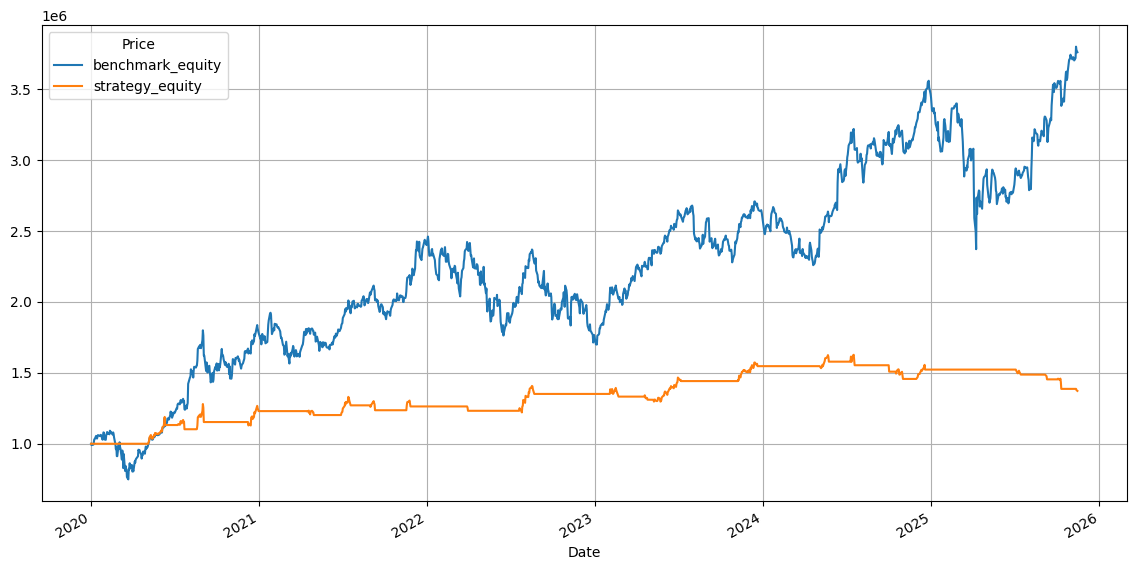

In [272]:
# Test 4
# 加入保護性止盈策略
buy_factors = [
    {"class": BreakoutBuyFactor, "xd": 60},
    {"class": BreakoutBuyFactor, "xd": 42},
]

# 先前的賣出因子調整
sell_factors = [
    {"class": BreakdownSellFactor, "xd": 120},
    # 加上ATR止盈止損
    {"class": AtrStopSellFactor, "stop_loss_n": 0.5, "stop_win_n": 3.0},
    # 加入風險控制策略
    {"class": RiskStopSellFactor, "pre_atr_n": 1.5},
    # 加入保護性止盈策略
    {"class": CloseAtrStopSellFactor, "close_atr_n": 1.2}
]

bt_test4 = Backtester(df, buy_factors=buy_factors, sell_factors=sell_factors, initial_capital=1_000_000)
result_df_test4, trades_df_test4, stats_test4 = bt_test4.run(show_plot=True)

print("=== 績效指標 ===")
for k, v in stats_test4.items():
    print(k, ":", v)

print("\n=== 交易紀錄（前 5 筆） ===")
print(trades_df_test4.head())

# 策略 vs 基準績效曲線
result_df_test4[["benchmark_equity", "strategy_equity"]].plot(figsize=(14, 7), grid=True)